In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [365]:
# Excelファイルの読み込み
excel_file_path = 'all_data.xlsx'
csv_file_path = 'all_data.csv'
df = pd.read_excel(excel_file_path, sheet_name=0)

# 削除する列のリスト
columns_to_drop = ['Density [kg/m^3]', '緯度', '経度', 'DO eq', '備考', '水深', 'pH', 'Pressure',
                  'O2 weiss 1970', 'DIC[μmol/L@25℃]', 'Depth[m]', 'DO[ µmol/kg]',
                  'TA [μmol/kg]', 'Salinity', '日時', '場所', 'No.']

# 指定された列を削除
df.drop(columns=columns_to_drop, inplace=True)

df = df[df['label'] != -1]

# CSVファイルとして保存
df.to_csv(csv_file_path, index=False)
print(f"CSVファイルが保存されました: {csv_file_path}")
df

CSVファイルが保存されました: all_data.csv


,pCO2,AOU,excess DIC,T,nDIC+0.768DO,DIC-0.5TA+0.83DO,DO Saturation,label
18,609.054405,5.103117,65.754199,26.1010,2234.610383,1053.148478,0.975200,1
135,564.930029,12.868835,49.888406,18.0400,2285.756471,1132.068050,0.945459,1
136,566.704024,16.336327,50.400634,18.0700,2283.360541,1129.289180,0.930744,1
137,569.721742,8.624603,51.355938,18.2300,2288.770308,1135.138190,0.963304,1
138,568.501477,12.060292,50.985970,18.1700,2286.217390,1132.425550,0.948760,1
...,...,...,...,...,...,...,...,...
2060,542.771000,118.587515,49.811000,10.6016,2265.132400,1143.534000,0.521004,0
2061,557.977000,130.831224,53.484000,10.1420,2265.232200,1141.832000,0.483192,0
2062,519.493000,119.491733,43.128000,10.7688,2255.845200,1134.107000,0.516312,0
2063,538.981000,128.104189,48.153000,10.0288,2263.360400,1140.654000,0.493668,0


In [366]:
import random
import numpy as np

In [472]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# コードの先頭で実行
set_seed()

In [484]:
class CustomNN(nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.input = nn.Linear(7,4) #input layer
        self.hidden1 = nn.Linear(4,2) #hidden layer 1
        # self.hidden2 = nn.Linear(4, 3) #hidden layer 2
        # self.hidden3 = nn.Linear(3, 2) #hidden layer 3
        # self.hidden4 = nn.Linear(3, 2) #hidden layer 3
        self.output = nn.Linear(2, 1) # output layer
        self.relu = nn.ReLU()          #define activation function
        self.tanh=nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.input(x))     #determine activation function for different layers
        x = self.relu(self.hidden1(x))
        # x = self.relu(self.hidden2(x))
        # x = self.relu(self.hidden3(x))
        # x = self.relu(self.hidden4(x))
        x = self.sigmoid(self.output(x))  #activation function for output: sigmoid
        return x

# Create the NN model
model = CustomNN()

In [550]:
X = df.drop('label', axis=1)
y = df['label']
# 層化抽出でデータを分割（9:1）
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)
# データの形状を確認
print("X shape:", X_train_tensor.shape)
print("y shape:", y_train_tensor.shape)
print("X shape:", X_test_tensor.shape)
print("y shape:", y_test_tensor.shape)

X shape: torch.Size([1477, 5])
y shape: torch.Size([1477, 1])
X shape: torch.Size([370, 5])
y shape: torch.Size([370, 1])


In [551]:
# Defining loss function and optimizer (mainly for the training process)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)
# the smaller lr is, the slower the decrease of loss function is

In [552]:
# Record the process of the change of loss function
losses = []

# Traning model
for epoch in range(10000):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch+1) % 1000 == 0:  # record the loss value every 2000 epochs
        print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')


Epoch [1000/10], Loss: 0.9574
Epoch [2000/10], Loss: 0.9562
Epoch [3000/10], Loss: 0.9550
Epoch [4000/10], Loss: 0.9536
Epoch [5000/10], Loss: 0.9521
Epoch [6000/10], Loss: 0.9504
Epoch [7000/10], Loss: 0.9484
Epoch [8000/10], Loss: 0.9460
Epoch [9000/10], Loss: 0.9430
Epoch [10000/10], Loss: 0.9388


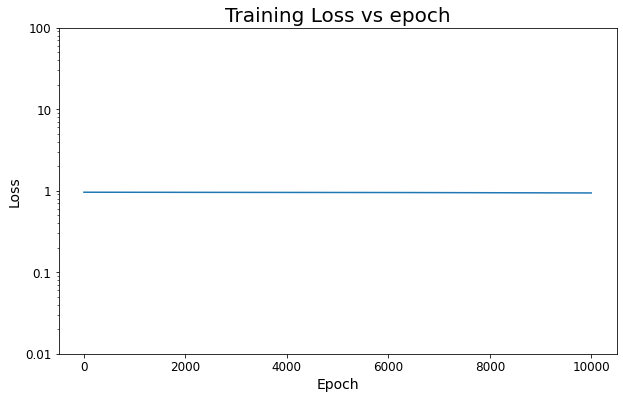

In [553]:
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss vs epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(False)
plt.yscale('log')
plt.yticks([0.01, 0.1, 1, 10, 100], ['0.01', '0.1', '1', '10', '100'], fontsize=12)
plt.xticks(fontsize=12)
plt.show()

In [531]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# モデルを評価モードに設定
model.eval()

# テストデータで予測
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # 確率から予測クラスに変換（二値分類の場合）
    y_pred_class = (y_pred >= 0.5).float()

# NumPy配列に変換
y_pred_np = y_pred_class.numpy()
y_test_np = y_test_tensor.numpy()

# 各種評価指標を計算
accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.0162
Precision: 0.0162
Recall: 1.0000
F1 Score: 0.0319


In [190]:
# データの形状を確認
print("y_pred_np shape:", y_pred_np.shape)
print("y_test_np shape:", y_test_np.shape)

# データの中身も確認
print("\nFirst few predictions:")
print(y_pred_np[:400])

y_pred_np shape: (370, 1)
y_test_np shape: (370, 1)

First few predictions:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]


In [548]:
###生データ
# Excelファイルの読み込み
excel_file_path = 'all_data.xlsx'
csv_file_path = 'all_data.csv'
df = pd.read_excel(excel_file_path, sheet_name=0)

df = df[df['label'] != -1]

# 削除する列のリスト
columns_to_drop = ['水深','Density [kg/m^3]', '緯度', '経度', 'DO eq', '備考', 'pH', 'Pressure',
                  'O2 weiss 1970', '日時', '場所', 'No.', 'T', 'Salinity', 'AOU', 'excess DIC', 'nDIC+0.768DO','DIC-0.5TA+0.83DO', 'DO Saturation']

# 指定された列を削除
df.drop(columns=columns_to_drop, inplace=True)

# CSVファイルとして保存
df.to_csv(csv_file_path, index=False)
print(f"CSVファイルが保存されました: {csv_file_path}")
df

CSVファイルが保存されました: all_data.csv


,pCO2,TA [μmol/kg],DO[ µmol/kg],Depth[m],DIC[μmol/L@25℃],label
18,609.054405,2153.3,201.181294,14.5756,1962.818004,1
135,564.930029,2230.0,223.335000,18.3100,2061.700000,1
136,566.704024,2229.6,219.746000,16.5800,2061.700000,1
137,569.721742,2229.6,226.793000,17.6600,2061.700000,1
138,568.501477,2229.7,223.585000,16.0000,2061.700000,1
...,...,...,...,...,...,...
2060,542.771000,2325.8,149.800000,765.5000,2182.100000,0
2061,557.977000,2322.4,140.400000,765.7000,2186.500000,0
2062,519.493000,2326.1,147.900000,765.8000,2174.400000,0
2063,538.981000,2323.8,143.800000,765.8000,2183.200000,0


In [549]:
###生データ

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# コードの先頭で実行
set_seed()

class CustomNN(nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.input = nn.Linear(5, 4) #input layer
        self.hidden1 = nn.Linear(4,3) #hidden layer 1
        # self.hidden2 = nn.Linear(3, 2) #hidden layer 2
        # self.hidden3 = nn.Linear(4, 3) #hidden layer 3
        # self.hidden4 = nn.Linear(3, 2) #hidden layer 3
        self.output = nn.Linear(3, 1) # output layer
        self.relu = nn.ReLU()          #define activation function
        self.tanh=nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.input(x))     #determine activation function for different layers
        x = self.relu(self.hidden1(x))
        # x = self.relu(self.hidden2(x))
        # x = self.relu(self.hidden3(x))
        # x = self.relu(self.hidden4(x))
        x = self.sigmoid(self.output(x))  #activation function for output: sigmoid
        return x

# Create the NN model
model = CustomNN()